In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'


In [2]:
import sys

sys.path.append('/home/caio/dev/')

In [3]:


import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt


from evaluation import Evaluator
from bprMf.bpr_mf import  bprMFWithClickDebiasing, bprMf

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
interactions = pd.read_csv('movielens_1m_ratings.csv')[["user", "item", "rating"]]
interactions["relevant"] = interactions["rating"].apply(lambda r: int(r >= 4))
zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}
interactions["item"] = interactions["item"].map(zero_based_indexing)

In [6]:
interactions.groupby("user").agg({"item": list})

,item
user,
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,"[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 6..."
3,"[175, 176, 58, 177, 178, 179, 180, 64, 181, 18..."
4,"[63, 64, 208, 209, 210, 44, 48, 113, 124, 127,..."
5,"[218, 219, 220, 221, 222, 223, 224, 225, 59, 2..."
...,...
6036,"[1892, 2470, 1326, 558, 240, 33, 97, 450, 876,..."
6037,"[97, 256, 1118, 1120, 1492, 128, 2072, 1253, 6..."
6038,"[1615, 153, 1509, 1033, 206, 535, 1528, 1340, ..."


## Developing a MF model based using BPR opt


Now we'll generalize the previous implementation using implicit feedback data and applying BPR (Bayesian personalized ranking) loss function, so that the model is capable of building personalzied rankings for users

### Step 1 : adapt training data for BPR


BPR expects implicit feedback data and relative ordering in the training dataset

In [7]:

zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}
zero_based_indexing_u = {v: K for K, v in enumerate(interactions["user"].unique())}
interactions["item"] = interactions["item"].map(zero_based_indexing)
interactions["user"] = interactions["user"].map(zero_based_indexing_u)

### Temp: Creating bpr dataset with vector operations

### Step 2: Create a MF model using BPR loss function

In [8]:
n_users = interactions.user.max() + 1
n_items = interactions.item.max() + 1

In [9]:
n_users, n_items

(np.int64(6040), np.int64(3706))

In [10]:



model = bprMf(
                num_users=n_users,
                num_items=n_items,
                factors=50,
                reg_lambda=1e-6,
                n_epochs=10).to(device)

### Training the model

In [11]:
train_df = interactions.sample(frac=0.7)
test_df = interactions.loc[~interactions.index.isin(train_df.index)]

In [12]:
%%time
train_losses = model.fit(train_df, debug=False)

CPU times: user 2min 51s, sys: 1.12 s, total: 2min 53s
Wall time: 2min 49s


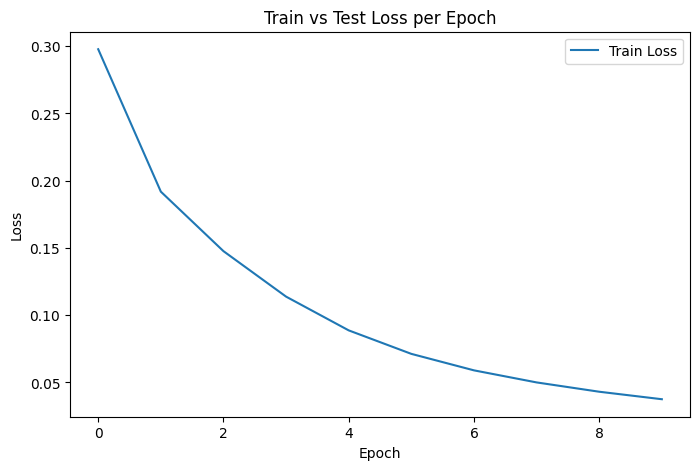

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.show()

In [14]:
train_df

,user,item,rating,relevant
158268,1014,1191,4,1
475463,2917,1203,4,1
692481,4142,399,4,1
71231,477,244,1,0
824741,4956,2,4,1
...,...,...,...,...
355974,2084,1317,3,0
999722,6036,336,3,0
997667,6024,2382,2,0
369425,2161,1232,4,1


In [15]:
interactions

,user,item,rating,relevant
0,0,0,5,1
1,0,1,3,0
2,0,2,3,0
3,0,3,4,1
4,0,4,5,1
...,...,...,...,...
1000204,6039,772,1,0
1000205,6039,1106,5,1
1000206,6039,365,5,1
1000207,6039,152,4,1


In [16]:
avg_test_loss = model.evaluate(test_df)

In [17]:
train_losses

[0.29874359449420246,
 0.19151657524566626,
 0.14760620148694978,
 0.1140768459219502,
 0.0891310886775356,
 0.07168438493405,
 0.059393159414002715,
 0.0503482232345132,
 0.04336332078307905,
 0.03782043858559758]

## Developing a BPR variant for click position debiasing

In [18]:
interactions["clicked_at"] = np.random.randint(0, 20, size=len(interactions))

In [19]:
interactions

,user,item,rating,relevant,clicked_at
0,0,0,5,1,18
1,0,1,3,0,10
2,0,2,3,0,12
3,0,3,4,1,5
4,0,4,5,1,16
...,...,...,...,...,...
1000204,6039,772,1,0,7
1000205,6039,1106,5,1,19
1000206,6039,365,5,1,6
1000207,6039,152,4,1,8


In [20]:
n_users = interactions.user.max() + 1
n_items = interactions.item.max() + 1

In [21]:
model = bprMFWithClickDebiasing(
                num_users=n_users,
                num_items=n_items,
                factors=50,
                reg_lambda=1e-3,
                n_epochs=10).to(device)




In [22]:
train_df = interactions.sample(frac=0.7)
test_df = interactions.loc[~interactions.index.isin(train_df.index)]

In [23]:
%%time
train_losses = model.fit(train_df)

CPU times: user 3min 13s, sys: 957 ms, total: 3min 14s
Wall time: 3min 11s


In [24]:
test_loss = model.evaluate(test_df)